In [1]:
from utils import *
from tokenizers import ByteLevelBPETokenizer
from pathlib import Path

from IPython.display import clear_output
from tqdm import tqdm, trange
import numpy as np
import pandas as pd

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.utils.rnn import pad_sequence

import datasets
import evaluate

import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.__version__

'2.1.0+cu121'

In [2]:
trainData = np.load('data/TOKENIZEDtrainData.npy')
validationData = np.load('data/TOKENIZEDvalidationData.npy')
trainLabels = pd.read_parquet('data/y_train.parquet').to_numpy()
validationLabels = pd.read_parquet('data/y_test.parquet').to_numpy()

In [2]:
df = pd.read_parquet('data/dataWithoutComments.parquet')
df = df.dropna()
x_train, x_test, y_train, y_test = download_train_test(df)

In [9]:
with open('data/ft_train.txt', 'w', encoding="utf-8") as f:
    for each_text, each_label in tqdm(zip(x_train['code'], y_train['language']), total=len(x_train)):
        f.writelines(f'{each_text}\n')
j
with open('data/ft_test.txt', 'w', encoding="utf-8") as f:
    for each_text, each_label in tqdm(zip(x_test['code'], y_test['language']), total=len(x_test)):
        f.writelines(f'{each_text}\n')

100%|████████████████████████████████████████████████████████████████████████| 244971/244971 [01:28<00:00, 2757.42it/s]


# Проверить траблууу

In [3]:
paths = [str(x) for x in Path('data/').glob('*.txt')]

# initialize
tokenizer = ByteLevelBPETokenizer()
# and train
tokenizer.train(files=paths, vocab_size=250000, min_frequency=2,
                special_tokens=['<|endoftext|>', '<s>', '<pad>', '</s>', '<unk>', '<mask>'], show_progress=True)

tokenizer.save_model('model/tokenizer/without comments')

['model/tokenizer/without comments\\vocab.json',
 'model/tokenizer/without comments\\merges.txt']

In [3]:
PATH = "model/tokenizer/without comments"

tokenizer = ByteLevelBPETokenizer(
            vocab = f'{PATH}/vocab.json', 
            merges= f'{PATH}/merges.txt', 
            add_prefix_space = True)

tokenizer.enable_truncation(max_length=512)

In [5]:
text = [''''# syntax: GAWK -f ASCENDING_PRIMES.AWK
BEGIN {
    start = 1
    stop = 23456789
    for (i=start; i<=stop; i++) {
      if (is_prime(i)) {
        primes++
        leng = length(i)
        flag = 1
        for (j=1; j<leng; j++) {
          if (substr(i,j,1) >= substr(i,j+1,1)) {
            flag = 0
            break
          }
        }
        if (flag) {
          printf("%9d%1s",i,++count%10?"":"\n")
        }
      }
    }
    printf("\n%d-%d: %d primes, %d ascending primes\n",start,stop,primes,count)
    exit(0)
}
function is_prime(n,  d) {
    d = 5
    if (n < 2) { return(0) }
    if (n % 2 == 0) { return(n == 2) }
    if (n % 3 == 0) { return(n == 3) }
    while (d*d <= n) {
      if (n % d == 0) { return(0) }
      d += 2
      if (n % d == 0) { return(0) }
      d += 4
    }
    return(1)
}''', '''// Ascending primes. Nigel Galloway: April 19th., 2022
[2;3;5;7]::List.unfold(fun(n,i)->match n with []->None |_->let n=n|>List.map(fun(n,g)->[for n in n.. -1..1->(n-1,i*n+g)])|>List.concat in Some(n|>List.choose(fun(_,n)->if isPrime n then Some n else None),(n|>List.filter(fst>>(<)0),i*10)))([(2,3);(6,7);(8,9)],10)
  |>List.concat|>List.sort|>List.iter(printf "%d "); printfn ""''']
enc = tokenizer.encode_batch(text)

In [6]:
tokenizer.encode_batch(text)

[Encoding(num_tokens=336, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=168, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [7]:
print(tokenizer.decode(enc[0].ids))

 '# syntax: GAWK -f ASCENDING_PRIMES.AWK
BEGIN {
    start = 1
    stop = 23456789
    for (i=start; i<=stop; i++) {
      if (is_prime(i)) {
        primes++
        leng = length(i)
        flag = 1
        for (j=1; j<leng; j++) {
          if (substr(i,j,1) >= substr(i,j+1,1)) {
            flag = 0
            break
          }
        }
        if (flag) {
          printf("%9d%1s",i,++count%10?"":"
")
        }
      }
    }
    printf("
%d-%d: %d primes, %d ascending primes
",start,stop,primes,count)
    exit(0)
}
function is_prime(n,  d) {
    d = 5
    if (n < 2) { return(0) }
    if (n % 2 == 0) { return(n == 2) }
    if (n % 3 == 0) { return(n == 3) }
    while (d*d <= n) {
      if (n % d == 0) { return(0) }
      d += 2
      if (n % d == 0) { return(0) }
      d += 4
    }
    return(1)
}


In [7]:
tokenizer.get_vocab()['<|endoftext|>']

0

In [8]:
tokenizer.get_vocab_size()

50000

In [8]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, emb_size=64, hid_size=128, num_classes=100):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc = inp_voc
        self.hid_size = hid_size
        self.eos_ix = self.inp_voc.get_vocab()['<|endoftext|>']
        
        self.emb_inp = nn.Embedding(inp_voc.get_vocab_size(), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.fc = nn.Linear(hid_size, num_classes)
        
    def forward(self, inp):
        ans = self.encode(inp)
        return ans


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        out = self.fc(last_state)
        return out

In [4]:
import torch.nn as nn

class LSTMNet(nn.Module):
    
    def __init__(self,vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        # Embedding layer converts integer sequences to vector sequences
        self.embedding = nn.Embedding(vocab_size, embedding_dim)#, sparse=True)
        
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first=True
                           )
        
        # Dense layer to predict 
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Prediction activation function
        #self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,text, text_lengths):
        #print(text.shape, text_lengths.shape)
        #text = text.T
        #print(text.shape, text_lengths.shape)
        embedded = self.embedding(text)
        #print(text.shape)
        # Thanks to packing, LSTM don't see padding tokens 
        # and this makes our model better
        #print(text_lengths.shape)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False, batch_first=True)
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        # Concatenating the final forward and backward hidden states
        #print(hidden_state.shape)# 4 64 128
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)

        #Final activation function
        #outputs=self.sigmoid(dense_outputs)
        
        return dense_outputs#outputs

In [5]:
def tokenize_batch(batch: np.array, tokenizer) -> list:
    encoding = tokenizer.encode_batch(batch)
    en_train_data = [torch.tensor(e.ids, dtype=torch.long) for e in encoding]
    return en_train_data

In [6]:
class Fitter(object):
    def __init__(
        self,
        model,
        opt,
        loss,
        train_dataloader,
        scheduler,
        test_dataloader,
        batch_size = 128,
        sheduler_steps = 10,
        n_epochs = 10
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.sheduler_steps = sheduler_steps

        self.opt = opt
        self.loss = loss
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        
        self.model.to(device)
        self.metrics = {'train_loss': [], 'dev_ROC-AUC': [],
                       'dev_accuracy': [], 'dev_F1': []}

    def fit(self):
        # Turn on training
        self.model.train(True)
        
        # Fit
        for epoch in range(self.n_epochs):
            train_loss = 0
            i = 0
            for (inps, targets) in tqdm(self.train_dataloader, desc='Работаем Братья'):
                targets = torch.tensor(targets, device=device)
                self.opt.zero_grad()
            
                pred = self.model(inps.to(device), torch.count_nonzero(inps, dim=1))
                loss = self.loss(pred, targets)
                loss.backward()
                self.opt.step()
                train_loss += loss.item()
                i += 1
            
            if epoch % self.sheduler_steps == 1:
                self.scheduler.step()
            
             
            self.model.eval()
            self.metrics['train_loss'] += [train_loss / (i+1)]
            preds = np.empty(0, dtype=np.int64)
            out_label_ids = np.empty(0, dtype=np.int64)
            
            with torch.no_grad():
                i = 0
                for (inps, targets) in tqdm(self.test_dataloader, desc='Валидация'):
                    
                    targets = torch.tensor(targets, device=device)
                    
                    pred =  self.model(inps.to(device), torch.count_nonzero(inps, dim=1))
                    pred = F.softmax(pred, dim=1).detach().argmax(dim=1).cpu().numpy()
                    preds = np.append(preds, pred, axis=0)
                    out_label_ids = np.append(out_label_ids, targets.argmax(dim=1).cpu(), axis=0)
                    i += 1
                    
            self.metrics['dev_accuracy'] += [simple_accuracy(preds, out_label_ids)]
            self.metrics['dev_F1'] += [f1_score(y_true=out_label_ids, y_pred=preds, average="macro")]

            if ((len(self.metrics['dev_accuracy']) > 2 and self.metrics['dev_accuracy'][-1] > self.metrics['dev_accuracy'][-2])
               or
                len(self.metrics['dev_accuracy']) == 1
               ):
                torch.save(self.model, 'model/rnn.pt')
            
            clear_output(wait=True) 
            plt.figure(figsize=(10, 5))
            
            plt.subplot(2, 2, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Train Loss")
            plt.grid()
            plt.plot(self.metrics['train_loss'])
            
            plt.subplot(2, 2, 2)
            plt.xlabel("Iteration")
            plt.ylabel("Accuracy")
            plt.plot(self.metrics['dev_accuracy'], color="orange")
            plt.grid()
            
            plt.subplot(2, 2, 3)
            plt.xlabel("Iteration")
            plt.ylabel("F1")
            plt.plot(self.metrics['dev_F1'], color="orange")
            plt.grid()
            
            plt.show()
            
            self.model.train(True)
            
        # Turn off training
        self.model.train(False)

In [7]:
class MyDataset(Dataset): 
    def __init__(self, inp, target):
        self.inp = inp
        self.target = target

        
    def __len__(self):
        return len(self.inp)
        
    def __getitem__(self, idx):
        return self.inp[idx], int(self.target[idx])

num_labels = len(np.unique(trainLabels))

def batch_collate_fn(batch):
    inps = [item[0] for item in batch]
    labels = np.array([item[1] for item in batch])
    out = np.zeros((len(labels), num_labels))
    out[np.arange(len(labels)), labels] = 1
    return torch.tensor(inps, dtype=torch.long), out

In [8]:
enc_dict = {x: y for y, x in enumerate(np.unique(trainLabels))}
dec_dict = {y: x for y, x in enumerate(np.unique(trainLabels))}

In [10]:
enc_dict = [
  'TGLANG_LANGUAGE_OTHER',
  'TGLANG_LANGUAGE_1S_ENTERPRISE',
  'TGLANG_LANGUAGE_ABAP',
  'TGLANG_LANGUAGE_ACTIONSCRIPT',
  'TGLANG_LANGUAGE_ADA',
  'TGLANG_LANGUAGE_APACHE_GROOVY',
  'TGLANG_LANGUAGE_APEX',
  'TGLANG_LANGUAGE_APPLESCRIPT',
  'TGLANG_LANGUAGE_ASP',
  'TGLANG_LANGUAGE_ASSEMBLY',
  'TGLANG_LANGUAGE_AUTOHOTKEY',
  'TGLANG_LANGUAGE_AWK',
  'TGLANG_LANGUAGE_BASIC',
  'TGLANG_LANGUAGE_BATCH',
  'TGLANG_LANGUAGE_BISON',
  'TGLANG_LANGUAGE_C',
  'TGLANG_LANGUAGE_CLOJURE',
  'TGLANG_LANGUAGE_CMAKE',
  'TGLANG_LANGUAGE_COBOL',
  'TGLANG_LANGUAGE_COFFESCRIPT',
  'TGLANG_LANGUAGE_COMMON_LISP',
  'TGLANG_LANGUAGE_CPLUSPLUS',
  'TGLANG_LANGUAGE_CRYSTAL',
  'TGLANG_LANGUAGE_CSHARP',
  'TGLANG_LANGUAGE_CSS',
  'TGLANG_LANGUAGE_CSV',
  'TGLANG_LANGUAGE_D',
  'TGLANG_LANGUAGE_DART',
  'TGLANG_LANGUAGE_DELPHI',
  'TGLANG_LANGUAGE_DOCKER',
  'TGLANG_LANGUAGE_ELIXIR',
  'TGLANG_LANGUAGE_ELM',
  'TGLANG_LANGUAGE_ERLANG',
  'TGLANG_LANGUAGE_FIFT',
  'TGLANG_LANGUAGE_FORTH',
  'TGLANG_LANGUAGE_FORTRAN',
  'TGLANG_LANGUAGE_FSHARP',
  'TGLANG_LANGUAGE_FUNC',
  'TGLANG_LANGUAGE_GAMS',
  'TGLANG_LANGUAGE_GO',
  'TGLANG_LANGUAGE_GRADLE',
  'TGLANG_LANGUAGE_GRAPHQL',
  'TGLANG_LANGUAGE_HACK',
  'TGLANG_LANGUAGE_HASKELL',
  'TGLANG_LANGUAGE_HTML',
  'TGLANG_LANGUAGE_ICON',
  'TGLANG_LANGUAGE_IDL',
  'TGLANG_LANGUAGE_INI',
  'TGLANG_LANGUAGE_JAVA',
  'TGLANG_LANGUAGE_JAVASCRIPT',
  'TGLANG_LANGUAGE_JSON',
  'TGLANG_LANGUAGE_JULIA',
  'TGLANG_LANGUAGE_KEYMAN',
  'TGLANG_LANGUAGE_KOTLIN',
  'TGLANG_LANGUAGE_LATEX',
  'TGLANG_LANGUAGE_LISP',
  'TGLANG_LANGUAGE_LOGO',
  'TGLANG_LANGUAGE_LUA',
  'TGLANG_LANGUAGE_MAKEFILE',
  'TGLANG_LANGUAGE_MARKDOWN',
  'TGLANG_LANGUAGE_MATLAB',
  'TGLANG_LANGUAGE_NGINX',
  'TGLANG_LANGUAGE_NIM',
  'TGLANG_LANGUAGE_OBJECTIVE_C',
  'TGLANG_LANGUAGE_OCAML',
  'TGLANG_LANGUAGE_OPENEDGE_ABL',
  'TGLANG_LANGUAGE_PASCAL',
  'TGLANG_LANGUAGE_PERL',
  'TGLANG_LANGUAGE_PHP',
  'TGLANG_LANGUAGE_PL_SQL',
  'TGLANG_LANGUAGE_POWERSHELL',
  'TGLANG_LANGUAGE_PROLOG',
  'TGLANG_LANGUAGE_PROTOBUF',
  'TGLANG_LANGUAGE_PYTHON',
  'TGLANG_LANGUAGE_QML',
  'TGLANG_LANGUAGE_R',
  'TGLANG_LANGUAGE_RAKU',
  'TGLANG_LANGUAGE_REGEX',
  'TGLANG_LANGUAGE_RUBY',
  'TGLANG_LANGUAGE_RUST',
  'TGLANG_LANGUAGE_SAS',
  'TGLANG_LANGUAGE_SCALA',
  'TGLANG_LANGUAGE_SCHEME',
  'TGLANG_LANGUAGE_SHELL',
  'TGLANG_LANGUAGE_SMALLTALK',
  'TGLANG_LANGUAGE_SOLIDITY',
  'TGLANG_LANGUAGE_SQL',
  'TGLANG_LANGUAGE_SWIFT',
  'TGLANG_LANGUAGE_TCL',
  'TGLANG_LANGUAGE_TEXTILE',
  'TGLANG_LANGUAGE_TL',
  'TGLANG_LANGUAGE_TYPESCRIPT',
  'TGLANG_LANGUAGE_UNREALSCRIPT',
  'TGLANG_LANGUAGE_VALA',
  'TGLANG_LANGUAGE_VBSCRIPT',
  'TGLANG_LANGUAGE_VERILOG',
  'TGLANG_LANGUAGE_VISUAL_BASIC',
  'TGLANG_LANGUAGE_WOLFRAM',
  'TGLANG_LANGUAGE_XML',
  'TGLANG_LANGUAGE_YAML']

enc_dict = {key: i for i, key in enumerate(enc_dict)}

In [11]:
SIZE_OF_VOCAB = tokenizer.get_vocab_size()
EMBEDDING_DIM = 128
NUM_HIDDEN_NODES = 64
NUM_OUTPUT_NODES = len(enc_dict)
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.2
batch_size = 64

model = LSTMNet(SIZE_OF_VOCAB,
                EMBEDDING_DIM,
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT
               ).to(device)

# model = BaseModel(tokenizer).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(opt, gamma=0.9)


train_dataset = MyDataset(trainData, np.array(list(map(enc_dict.get, trainLabels.T[0]))))
test_dataset = MyDataset(validationData, np.array(list(map(enc_dict.get, validationLabels.T[0]))))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn=batch_collate_fn, shuffle=True, drop_last=True,
                              pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             collate_fn=batch_collate_fn, shuffle=False,
                              pin_memory=True)

loss = nn.CrossEntropyLoss()

sheduler_steps = 1
epochs = 5

fitter =  Fitter(
                model,
                opt,
                loss,
                train_dataloader,
                scheduler,
                test_dataloader,
                batch_size = batch_size,
                sheduler_steps = sheduler_steps,
                n_epochs = epochs,
)

In [13]:
fitter.metrics

{'train_loss': [0.4400647917949601],
 'dev_ROC-AUC': [],
 'dev_accuracy': [0.9705801911246638],
 'dev_F1': [0.8046836725393447]}

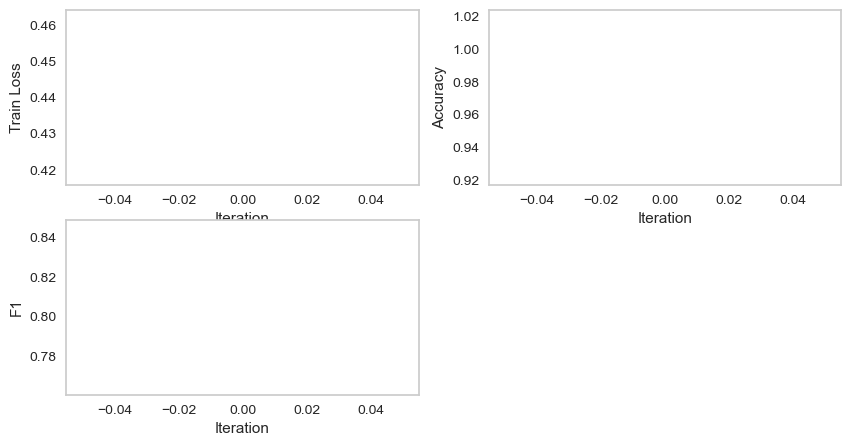

Работаем Братья:  31%|██████████▏                      | 4730/15310 [11:22<25:26,  6.93it/s]


KeyboardInterrupt: 

In [12]:
fitter.fit()